# Basic Abstraction And Presentation



## Assumptions


### 1. Code in `CODE_ROOT_FOLDER`

In [39]:
# change to point to the right folder on your mahchine where you cloned the Zeeguu-Core
CODE_ROOT_FOLDER = '/Users/mircea/Zeeguu-Core/'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER
def full_path(file_name):
    return CODE_ROOT_FOLDER+file_name

### 2. All the imports and functions from [DataGathering_Intro](Data_Gathering_Intro.ipynb)

In [16]:
import sys
import pathlib
from pathlib import Path
import re
import networkx as nx
import matplotlib.pyplot as plt

In [17]:
def LOC(file):
    return sum([1 for line in open(file)])

In [18]:
import re

def imports_in_text(module_text):
    regex = r"^(import|from)\s(\S+)"
    return set(
        match[1]
        for match in re.findall(regex,
                                module_text,
                                re.MULTILINE)
    )

def imports(file_name):
    with open(file_name) as f:
        return imports_in_text(f.read())
    

assert ("x" in imports_in_text("from x import y\nimport z"))
assert ("sqlalchemy" in imports(full_path('zeeguu_core/model/user.py')))

In [19]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. /Users/mircea/Zeeguu-Core/zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'zeeguu_core.model.user' == module(full_path('zeeguu_core/model/user.py'))

In [20]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.Graph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

In [21]:
def draw_graph(G):
    plt.figure(figsize=(10,6))
    nx.draw(G)
    plt.show()

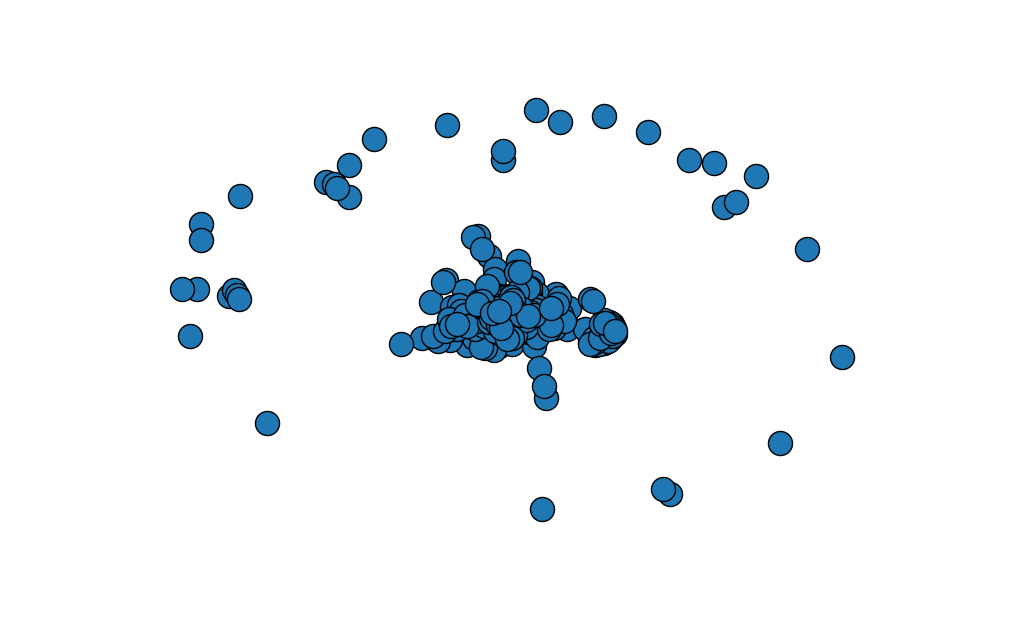

In [22]:
G = dependencies_graph()
draw_graph(G)

# 1. Basic Abstraction

### Aggregating Dependencies

   

In [23]:
def top_level_module(module_name, depth=1):
    # extracts the parent of depth X 
    # e.g. top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("zeeguu_core.model.util") == "zeeguu_core")
assert (top_level_module("zeeguu_core.model.util", 2) == "zeeguu_core.model")

In [24]:
def abstracted_to_top_level(G):
    """ returns only dependencies between top level modules"""
    aG = nx.Graph()
    
    for edge in G.edges():
        source_parent = top_level_module(edge[0])
        dest_parent = top_level_module(edge[1])
        aG.add_edge(source_parent, dest_parent)
        
    #     
    return aG

In [25]:
def draw_graph(G, size):
    plt.figure(figsize=size)
    nx.draw(G, with_labels=True)
    plt.show()

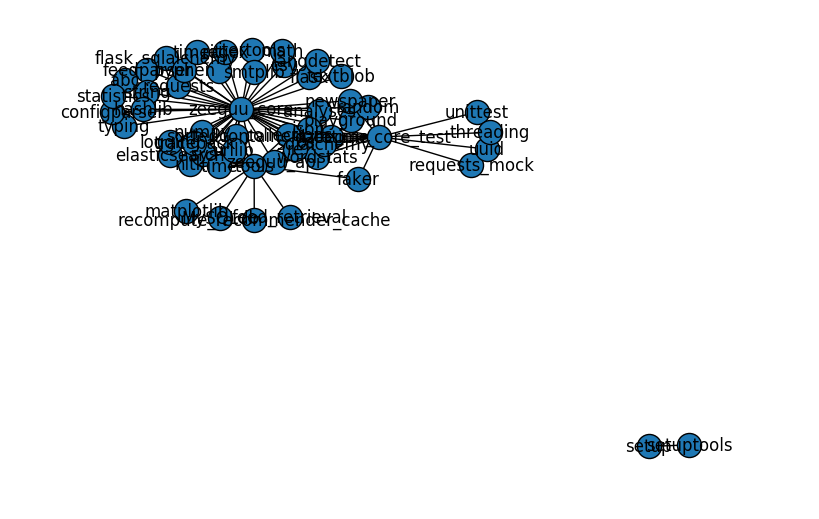

In [26]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph(aG, (8,5))

In [27]:
for line in open(full_path("requirements.txt")):
    print (line)

jieba3k

lxml

Pillow

pytest

flask

Flask-SQLAlchemy

mysqlclient

regex

feedparser

requests

newspaper3k==0.2.7

Faker

requests_mock

nltk

langdetect

sortedcontainers

elasticsearch

pyphen

numpy

wordstats



In [28]:
def internal_module(m):
    return 'zeeguu' in m

In [29]:
def abstracted_to_top_level(G):
    """ returns only dependencies between top level modules"""
    aG = nx.Graph()
    
    for edge in G.edges():
        source_parent = top_level_module(edge[0])
        dest_parent = top_level_module(edge[1])
        if internal_module(source_parent) and internal_module(dest_parent):
            aG.add_edge(source_parent, dest_parent)
        
    #     
    return aG

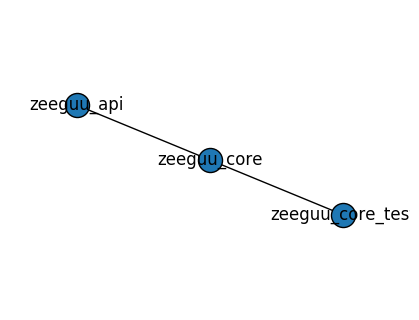

In [30]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph(aG, (4,3))

## Distinguishing System Modules 

## But Dependencies Have Directions...



In [31]:
def directed_dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

In [32]:
def directed_abstracted_to_top_level(G):
    """ returns only dependencies between top level modules"""
    aG = nx.DiGraph()
    
    for edge in G.edges():
        source_parent = top_level_module(edge[0])
        dest_parent = top_level_module(edge[1])
        if internal_module(source_parent) and internal_module(dest_parent):
            aG.add_edge(source_parent, dest_parent)
        
    #     
    return aG

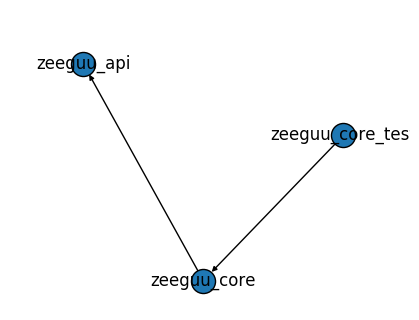

In [33]:
G = directed_dependencies_graph()
aG = directed_abstracted_to_top_level(G)
draw_graph(aG, (4,3))

## Capturing all the modules... e.g. tools

In [34]:
def internal_module(m):
    return m.startswith('zeeguu') or m=='tools' or m=='playground'

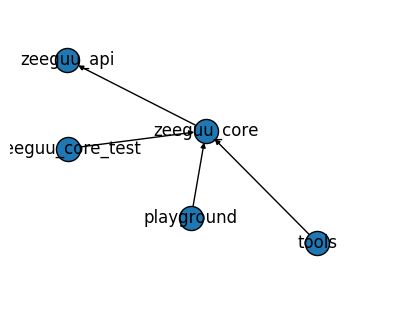

In [35]:
G = directed_dependencies_graph()
aG = directed_abstracted_to_top_level(G)
draw_graph(aG, (4,3))

# 2. Basic Presentation

### Showing `Properties` of Modules
- Remember the Definition of Architecture!


In [36]:
def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

module_size("zeeguu_core")

9339

In [37]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    
    node_weights = [weight_function(each) for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

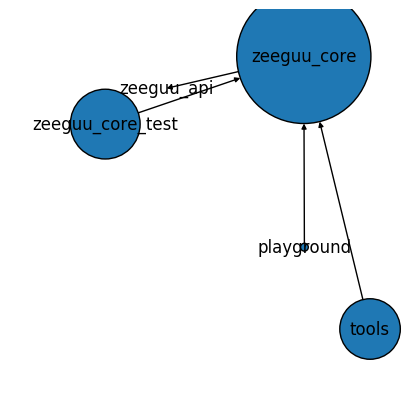

In [38]:
G = directed_dependencies_graph()
aG = directed_abstracted_to_top_level(G)
draw_graph_with_weights(aG, module_size, (4,4))

## Interactive Assignment
- Draw the architecture of the zeeguu_core itself!
- i.e. focus on the top level modules in zeeguu core



## To Try Out: 
- can you export this to another interactive exploration tool?